<a href="https://colab.research.google.com/github/DiyaSingla1012/Assignment6/blob/main/Assgn6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (1000, 6)


,arrival_rate,service_rate,capacity,sim_time,avg_wait,max_wait
0,2.920549,1.828293,2,736.277540,0.797492,5.510174
1,6.169885,3.432293,4,240.492616,0.010742,0.501994
2,9.106082,4.744069,2,576.769839,2.655773,9.301898
3,7.179501,3.555169,3,400.240959,0.098306,1.181116
4,8.148885,4.893638,1,191.839127,39.613104,78.502094



MODEL COMPARISON TABLE


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,MSE,R2
7,Extra Trees,88.430340,0.962050
8,XGBoost,222.804522,0.904383
1,Random Forest,236.410675,0.898544
3,Decision Tree,300.913690,0.870863
2,Gradient Boosting,434.880448,0.813371
9,MLP Neural Network,942.877126,0.595364
6,AdaBoost,998.753658,0.571384
0,Linear Regression,1623.439862,0.303300
4,KNN,1856.048888,0.203475
5,SVR,2625.077449,-0.126554



BEST MODEL
Model    Extra Trees
MSE         88.43034
R2           0.96205
Name: 7, dtype: object


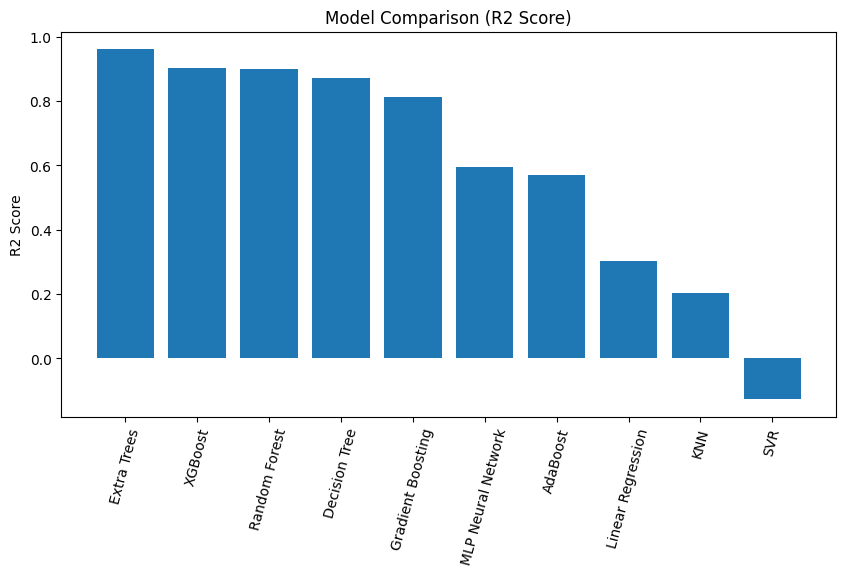

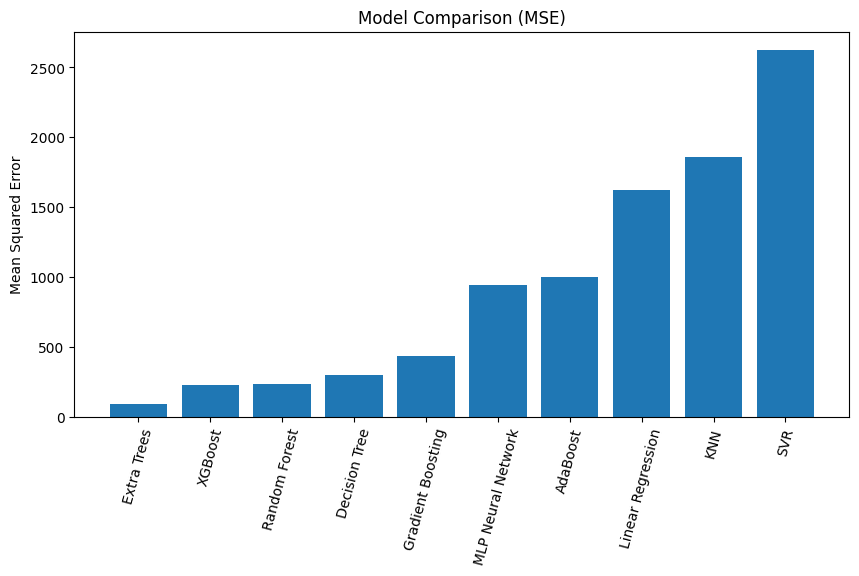

In [1]:
# -*- coding: utf-8 -*-
"""assgn06.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1VZ05MUJ0BS8tm54xeiCdubO4OwJKyoPX
"""

# =========================
# STEP 0: INSTALL PACKAGES
# =========================
!pip install simpy xgboost -q

# =========================
# STEP 1: IMPORT LIBRARIES
# =========================
import simpy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

# =========================
# STEP 2: SIMULATION MODEL
# =========================
def run_simulation(arrival_rate, service_rate, capacity, sim_time):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=capacity)

    wait_times = []

    def customer(env):
        arrival_time = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrival_time)
            yield env.timeout(random.expovariate(service_rate))

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    return {
        "arrival_rate": arrival_rate,
        "service_rate": service_rate,
        "capacity": capacity,
        "sim_time": sim_time,
        "avg_wait": sum(wait_times)/len(wait_times) if wait_times else 0,
        "max_wait": max(wait_times) if wait_times else 0
    }

# =========================
# STEP 3: GENERATE DATASET
# =========================
records = []

for i in range(1000):
    arrival_rate = random.uniform(1, 10)
    service_rate = random.uniform(1, 8)
    capacity = random.randint(1, 5)
    sim_time = random.uniform(100, 1000)

    result = run_simulation(arrival_rate, service_rate, capacity, sim_time)
    records.append(result)

df = pd.DataFrame(records)

print("Dataset Shape:", df.shape)
display(df.head())

# =========================
# STEP 4: TRAIN-TEST SPLIT
# =========================
X = df[["arrival_rate", "service_rate", "capacity", "sim_time"]]
y = df["avg_wait"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# STEP 5: ML MODELS
# =========================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "AdaBoost": AdaBoostRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror"),
    "MLP Neural Network": MLPRegressor(max_iter=500)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append([name, mse, r2])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "R2"])
results_df = results_df.sort_values(by="R2", ascending=False)

print("\nMODEL COMPARISON TABLE")
display(results_df)

# =========================
# STEP 6: BEST MODEL
# =========================
best_model = results_df.iloc[0]
print("\nBEST MODEL")
print(best_model)

# =========================
# STEP 7: VISUALIZATION
# =========================
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["R2"])
plt.xticks(rotation=75)
plt.ylabel("R2 Score")
plt.title("Model Comparison (R2 Score)")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["MSE"])
plt.xticks(rotation=75)
plt.ylabel("Mean Squared Error")
plt.title("Model Comparison (MSE)")
plt.show()